In [ ]:
#%tensorflow_version 2.x
#TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
import os

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d srinivasbece/brain-tumor-databasebtd600

import zipfile
with zipfile.ZipFile("brain-tumor-databasebtd600.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/btd600")

train_path = "/content/btd600/Brain Tumor Database(BTD-660)/training"
test_path = "/content/btd600/Brain Tumor Database(BTD-660)/testing"
validation_path = "/content/btd600/Brain Tumor Database(BTD-660)/validation"

class_names = ['benign', 'malignent']



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/srinivasbece/brain-tumor-databasebtd600
License(s): CC0-1.0
brain-tumor-databasebtd600.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#Preprocess training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150), #Adjusting the target size as needed
    batch_size=32,
    class_mode='binary',
    classes=class_names
)

# Preprocess validation data (only rescale, no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    classes=class_names,
    shuffle=False # Not strictly necessary for validation but good practice
)

#Preprocess testing data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150), #Adjusting the target size as needed
    batch_size=32,
    class_mode='binary',
    classes=class_names,
    shuffle=False  #Keep order for evaluation
)
#Defining the model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)), #Input shapes adjusted for color images
    keras.layers.MaxPooling2D((2, 2)),
    # keras.layers.Dropout(0.1),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    # keras.layers.Dropout(0.1),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    # keras.layers.Dropout(0.1),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    #  keras.layers.Dropout(0.2), # Add Dropout before the final classification layer
    keras.layers.Dense(1, activation='sigmoid') # Output layer for binary classification
])

#Compiling the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True # Restore model weights from the epoch with best val_loss
)

# Training the model with validation data and early stopping
model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

#Evaluating the model
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

print('Test accuracy:', test_acc)

Found 400 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.4703 - loss: 0.7210 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4844 - loss: 0.6997 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5189 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6951
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5364 - loss: 0.6920 - val_accuracy: 0.3000 - val_loss: 0.6974
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5704 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5481 - loss: 0.6913 - val_accuracy: 0.4500 - val_loss: 0.6955
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7609 - loss: 0.6823
Test accuracy: 0.5


Total test samples available: 240
Predicting for random sample at index: 193
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


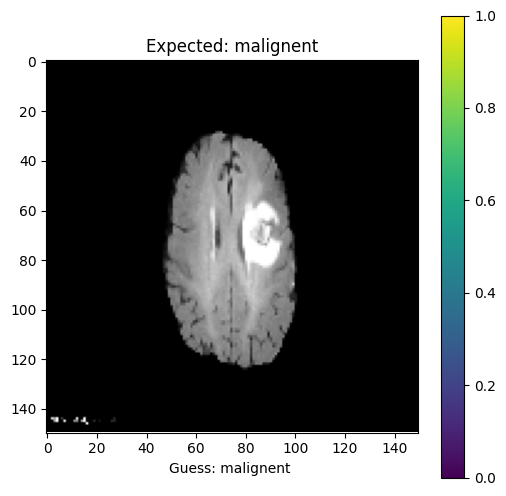

In [ ]:
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR

# --- CHANGE 1: Update class_names for your new dataset ---
class_names = ['benign', 'malignent']

def predict(model, image_array, correct_label):
    # Add the batch dimension (model expects input shape like (1, 150, 150, 3))
    prediction = model.predict(np.expand_dims(image_array, axis=0))

    # --- CHANGE 2: Adapt prediction logic for binary (sigmoid) output ---
    # For binary classification with sigmoid activation (output neuron 1),
    # the prediction is a single probability for the positive class (malignant).
    # If this probability is > 0.5, it's 'malignant' (index 1), otherwise 'benign' (index 0).
    predicted_probability = prediction[0][0] # Access the single probability value
    if predicted_probability > 0.5:
        predicted_class_index = 0 # Corresponds to 'malignant'
    else:
        predicted_class_index = 1 # Corresponds to 'benign'

    predicted_class_name = class_names[predicted_class_index]
    true_class_name = class_names[correct_label] # correct_label will be 0 or 1 from generator

    # --- CHANGE 3: Adjust title/xlabel to show probability ---
    # You might want to display the probability as well for binary output
    show_image(image_array, true_class_name, predicted_class_name, predicted_probability)

def show_image(img, label, guess, probability):
    plt.figure(figsize=(6, 6)) # Adjust figure size for better display
    plt.imshow(img)
    plt.title(f"Expected: {label}", color=COLOR)
    # Display probability along with guess
    plt.xlabel(f"Guess: {guess} ", color=COLOR)
    plt.colorbar()
    plt.grid(False)
    plt.show()

def get_number(max_index):
    while True:
        num_str = input(f"Pick a number between 0 and {max_index}: ")
        if num_str.isdigit():
            num = int(num_str)
            if 0 <= num <= max_index:
                return num
            else:
                print(f"Number out of range. Please pick a number between 0 and {max_index}.")
        else:
            print("Invalid input. Please enter a whole number.")

# --- Make sure these variables are accessible from your training code ---
# Getting the labels from the test generator
# Note: test_generator should be defined from your previous training setup
test_labels = test_generator.classes

# Getting the filenames from the test generator
test_filenames = test_generator.filenames

# Getting the total number of test samples
num_test_samples = len(test_generator.filenames)

# --- Code to pick a random image for prediction ---
print(f"Total test samples available: {num_test_samples}")
if num_test_samples == 0:
    print("No test samples found. Please check your test_generator setup.")
else:
    import random
    random_index = random.randint(0, num_test_samples - 1)
    print(f"Predicting for random sample at index: {random_index}")

    # Ensure test_path is correctly set from your previous code
    img_path = os.path.join(test_path, test_filenames[random_index])

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0 # Normalize pixel values to [0, 1]

    # Get the true label for this image
    label = test_labels[random_index]

    # Call the prediction function
    predict(model, img_array, label)

# --- Code to ask the user to pick an input index (uncomment to use) ---
# if num_test_samples > 0:
#     print("\n--- Or pick a specific image to predict ---")
#     num = get_number(num_test_samples - 1)
#     img_path_user = os.path.join(test_path, test_filenames[num])
#     img_user = image.load_img(img_path_user, target_size=(150, 150))
#     img_array_user = image.img_to_array(img_user) / 255.0
#     label_user = test_labels[num]
#     predict(model, img_array_user, label_user)